![Cognitive Science Logo](https://pbs.twimg.com/profile_images/647528050364579842/OOg_abEb.jpg)

# <center> Common Object Representations for Visual Production and Recognition </center>
## <center> Judith E. Fan, Daniel L. K. Yamins, Nicholas B. Turk-Browne </center>

***

## Краток опис на трудот

Во овој труд се зборува за корелацијата помеѓу карактеристиките кои визуелниот кортекст на човекот ги создава за објекти при визуелно препознавање (гледање, набљудување) и при цртање на истите. Се поставува прашањето дали човекот на ист начин ги перципира објектите при набљудување и при нивно исцртување. Овој труд, како и секој труд од доменот на когнитивните науки, е значаен бидејќи дава одговори на прашања за енигмата која се наоѓа во нашиот череп. Резултатите од овој труд покажуваат значајна корелација помеѓу гореспоменатите карактеристики и објаснуваат зошто цртањето претставува толку ефективна алатка за комуникација на визуелни концепти. Се прави претпоставка дека препознаените објекти на цртежите од податочното множество од страна на човекот се точни, и користејќи длабоки невронски мрежи за препознавање врз истите цртежи се извлекуваат карактеристиките на нацртаните објекти, како и на фотографии од истите. Вреди да се напомене дека длабоката невронска мрежа е модел на IT кортексот во човековиот мозок. Споредувајќи ги човековите предвидувања и предвидувањата на моделот се забележува висока точност, што означува дека моделот е задоволителен. Понатаму, во трудот се извршуваат и други истражувања, кои се базираат на прашањата дали со вежбање на цртање на објектите се подобрува визуелната репрезентација за истите, дали доколку вежбаме цртање на објекти со помошен визуелен стимул (фотографија од објектот) ќе добиеме иста промена врз визуелната репрезентација како кога би вежбале цртање без никаков помошен стимул.

***


Note: Како статистички тест во овој труд се користи Spearman's rank коефициентот на корелација. За да се пресмета овој коефициент се користи формулата:

$$
\rho = 1 - \frac{6 \sum{d^2_i}}{n(n^2-1)}
$$
Или целосната формула:
$$
\rho = \frac{\frac{1}{n} \sum_{i=1}^n \big(R(x_i) - \overline{R(x)} \big) \cdot %
       \big(R(y_i) - \overline{R(y)} \big)}{%
       \sqrt{\Big( \frac{1}{n} \sum_{i=1}^n \big(R(x_i) - \overline{R(x)} \big)^2 \Big) \cdot %
       \Big( \frac{1}{n} \sum_{i=1}^n \big(R(y_i) - \overline{R(y)} \big)^2 \Big)}}
$$

## Вчитување на моделот и податоците

In [1]:
from __future__ import division
import numpy as np

import matplotlib
import seaborn as sns
import prettyplotlib as ppl
from matplotlib import pylab, mlab, pyplot
from functools import reduce
from pylab import *
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
cm = matplotlib.cm
%matplotlib inline

import pandas as pd
import json
import sys
import os
import copy

In [2]:
data_dir = './data'

CURR_DIR = os.getcwd()

if os.path.join(CURR_DIR) not in sys.path:
    sys.path.append(CURR_DIR)

In [3]:
from data.inet_sketch_cats import CATS
Cats = CATS

## standardized ordering of categories for ease of visualization
from data.inet_sketch_cats import STANDARD_ORDER
standard_order = STANDARD_ORDER

## standardized ordering of categories for ease of visualization
from data.inet_sketch_cats import SKLOOP_OBJS
skloop_objs = SKLOOP_OBJS

## load dictionary with correpsondences between Imagenet and Eitz labels
from data.inet_sketch_cats import INET_TO_SKETCH
inet_to_sketch = INET_TO_SKETCH

## load in dictionary with cluster assignments
from data.inet_sketch_cats import CLUSTER_OBJ_LIST
clusterObjList = CLUSTER_OBJ_LIST
clusterObjList = reduce(lambda x, y: list(x) + list(y), clusterObjList.values())

In [4]:
meta_eitz = pd.read_csv(os.path.join(data_dir,'meta_eitz.csv'))
correspondence = dict([(x, x) for x in np.unique(meta_eitz['category'])])
correspondence['crane'] = 'crane (machine)'
correspondence['loudspeakers'] = 'loudspeaker'
correspondence['loudspeaker'] = 'loudspeakers'

In [5]:
imF_means_layer1 = np.load(os.path.join(data_dir,'inet_class_means_layer1.npy'))
imF_means_fc6 = np.load(os.path.join(data_dir,'inet_class_means_fc6.npy'))

skF_means_layer1 = np.load(os.path.join(data_dir,'eitz_class_means_layer1.npy'))
skF_means_fc6 = np.load(os.path.join(data_dir,'eitz_class_means_fc6.npy'))

# load in other layers
skF_means_layer2 = np.load(os.path.join(data_dir,'eitz_class_means_layer2.npy'))
skF_means_layer3 = np.load(os.path.join(data_dir,'eitz_class_means_layer3.npy'))
skF_means_layer4 = np.load(os.path.join(data_dir,'eitz_class_means_layer4.npy'))
skF_means_layer5 = np.load(os.path.join(data_dir,'eitz_class_means_layer5.npy'))

imF_means_layer2 = np.load(os.path.join(data_dir,'inet_class_means_layer2.npy'))
imF_means_layer3 = np.load(os.path.join(data_dir,'inet_class_means_layer3.npy'))
imF_means_layer4 = np.load(os.path.join(data_dir,'inet_class_means_layer4.npy'))
imF_means_layer5 = np.load(os.path.join(data_dir,'inet_class_means_layer5.npy'))

assert imF_means_fc6.shape[0] == 105
assert skF_means_fc6.shape[0] == 105

## Функции за исцртување на корелацијата помеѓу карактеристиките (код даден од авторите на трудот)

In [6]:
def plot_rdm(X,size):
    sns.set_style('white')
    sns.set_context('paper')
    fig = plt.figure(figsize=(size,size))
    fig.gca().matshow(X,cmap=cm.inferno)
    plt.xticks(range(len(standard_order)), standard_order, rotation=90);
    plt.yticks(range(len(standard_order)), standard_order); 

    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False
        
def plot_rdms_adjacent(X1,X2):
    '''
    X1 = feature means within each class for bottom layer
    X2 = feature means within each class for top layer    
    '''
    import seaborn as sns
    import matplotlib.cm as cm
    sns.set_style('white')
    sns.set_context('paper')
    fig = plt.figure(figsize=(24,12))
    
    plt.subplot(1,2,1)
    ax = fig.gca().matshow(X1,cmap=cm.inferno)
    plt.xticks(range(len(standard_order)), standard_order, rotation=90);
    plt.yticks(range(len(standard_order)), standard_order); 
    plt.colorbar(ax)

    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False    
        
    plt.subplot(1,2,2)       
    fig.gca().matshow(X2,cmap=cm.inferno)
    plt.xticks(range(len(standard_order)), standard_order, rotation=90);
    plt.yticks(range(len(standard_order)), standard_order); 

    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False

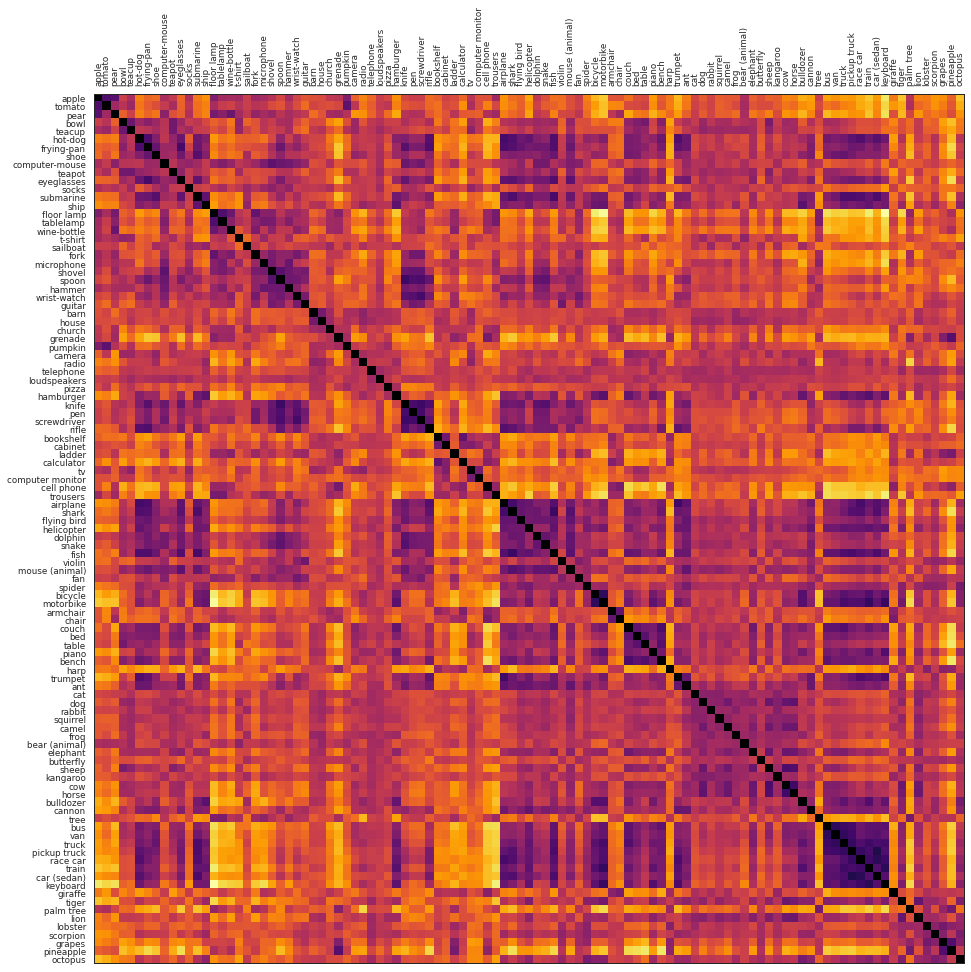

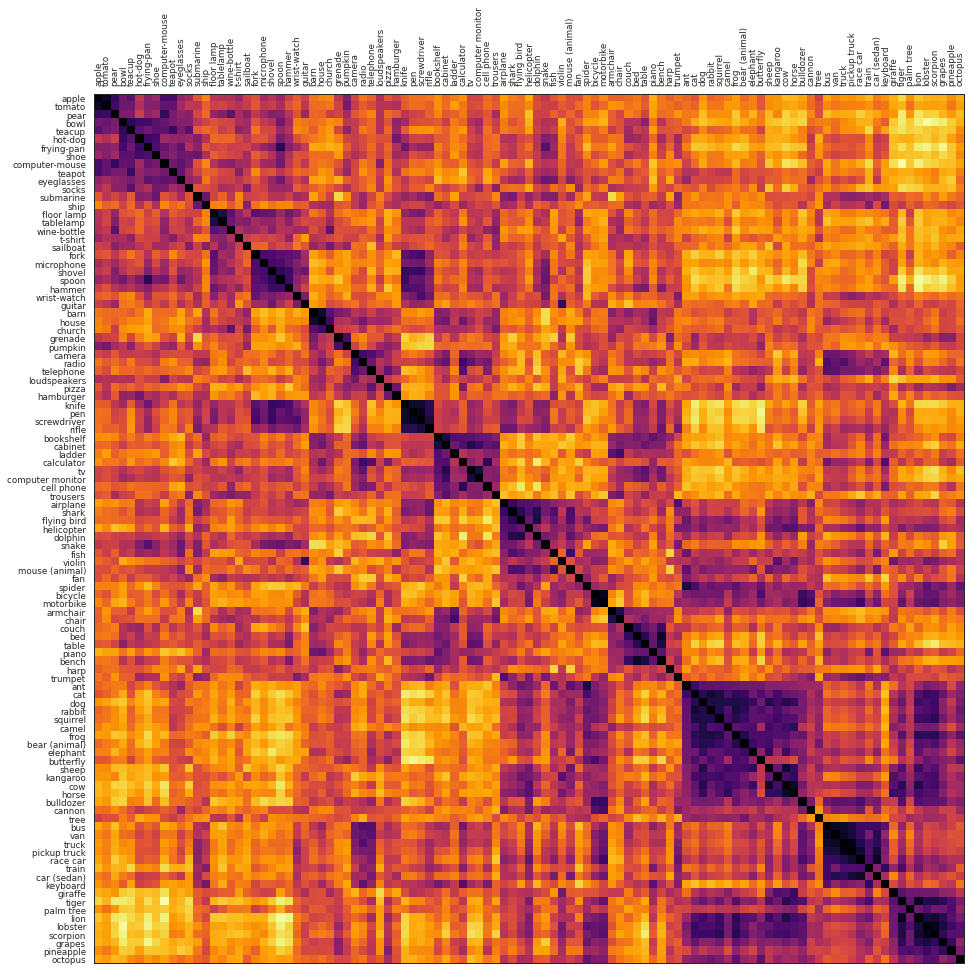

In [7]:
import warnings
warnings.filterwarnings('ignore')

### Plot RDMs based on bottom ('layer1') and top ('fc6') layer feature representations for sketch domain (Eitz corpus)
sketch_rdm_layer1 = 1 - np.corrcoef(skF_means_layer1)
sketch_rdm_fc6 = 1 - np.corrcoef(skF_means_fc6)
plot_rdm(sketch_rdm_layer1, 16)
plot_rdm(sketch_rdm_fc6, 16)

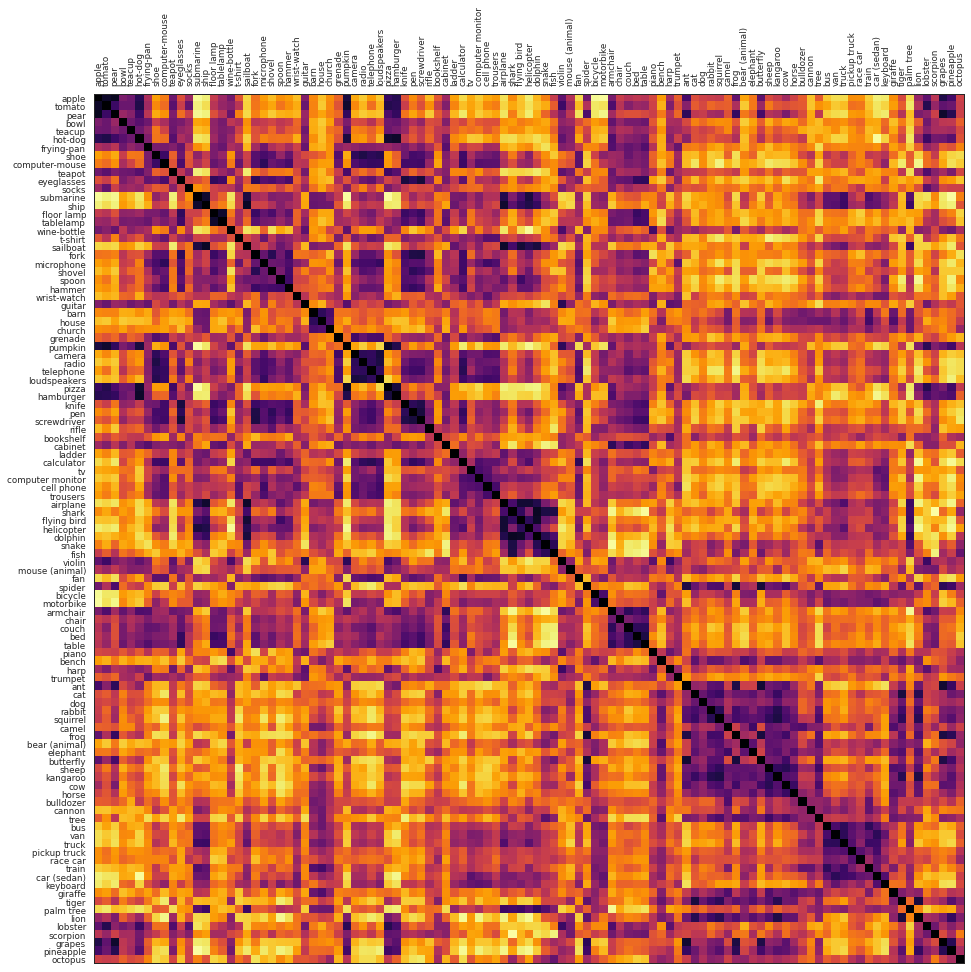

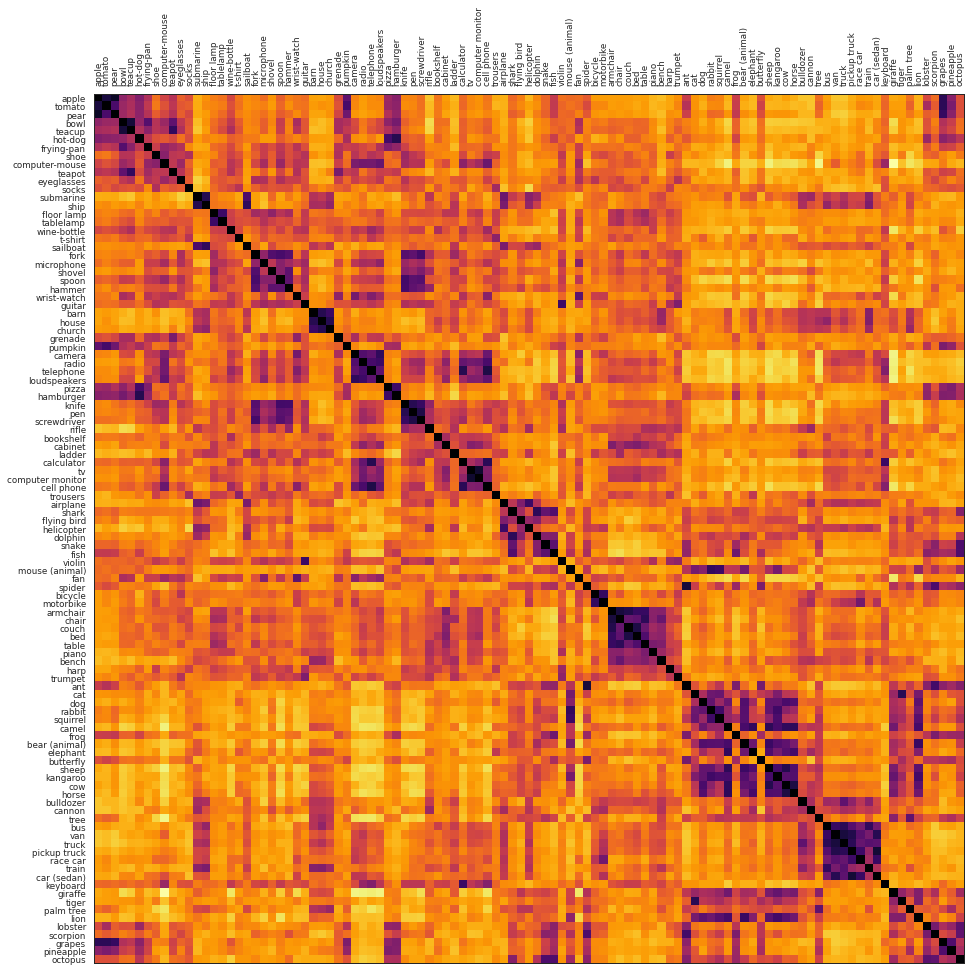

In [8]:
### Plot RDMs based on bottom ('layer1') and top ('fc6') layer feature representations for photo domain (Imagenet)
photo_rdm_layer1 = 1 - np.corrcoef(imF_means_layer1)
photo_rdm_fc6 = 1 - np.corrcoef(imF_means_fc6)
plot_rdm(photo_rdm_layer1, 16)
plot_rdm(photo_rdm_fc6, 16)

### Можеме да забележиме дека овие визуелизации не ни даваат многу информации сами по себе, односно би требало да ги проучуваме детално за да разбереме што сакале да доловат авторите за нивниот модел


### За таа цел, дефинирам функција во која со помош на Plotly ќе ги визуелизирам овие RDM. Со ваквите визуелизации при hover со покажувачот ќе се прикаже која ќелија за кои објекти одговара, како и опцијата да се направи zoom над одредена подгрупа од објекти за да се испита подетално

In [27]:
import plotly.express as px

def draw_with_plotly(X, title=""):
    fig = px.imshow(X, width=950, height=950, x=standard_order, y=standard_order, title=title)
    fig.show()

In [29]:
draw_with_plotly(sketch_rdm_layer1, "Layer 1 RDM on sketches")
draw_with_plotly(sketch_rdm_fc6, "Last layer RDM on sketches")
draw_with_plotly(photo_rdm_layer1, "Layer 1 RDM on photos")
draw_with_plotly(photo_rdm_fc6, "Last layer RDM on photos")

### Бидејќи податоците користени во овој труд беа преголеми за да се постават на GitHub, нив треба да ги симнете од следниот [линк](https://figshare.com/articles/common_repns_production_recognition_data/4503092) и да ги копирате во data/ директориум кој се наоѓа на исто место со оваа тетратка